# Path analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import *

import igraph as ig # Need to install this in your virtual environment

import psycopg2
from re import sub

import editdistance # Needs to be installed

# from pymining import seqmining

In [3]:
# import os
# import sys
# sys.path.append('/home/mmalik/optourism-repo' + "/pipeline")
# from firenzecard_analyzer import *

In [2]:
# TODO: connect with dbutils
conn_str = ""
conn = psycopg2.connect(conn_str)
cursor = conn.cursor()

Then, load the data (takes a few moments):

In [5]:
nodes = pd.read_sql('select * from optourism.firenze_card_locations', con=conn)
nodes.head()

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b


In [16]:
df = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
df['museum_id'].replace(to_replace=39,value=38,inplace=True)
df['short_name'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['short_name'])))
df['string'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['string'])))
df['date'] = pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df['hour'] = pd.to_datetime(df['date']) + pd.to_timedelta(pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.hour, unit='h')
df.head()

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id,short_name,string,date,hour
0,2089098,Palazzo Pitti,2016-09-19 14:49:00,0,1,1,0,38,Pitti,P,2016-09-19,2016-09-19 14:00:00
1,2089099,Palazzo Pitti,2016-09-19 14:49:00,0,1,1,0,38,Pitti,P,2016-09-19,2016-09-19 14:00:00
2,2083344,Palazzo Pitti,2016-09-19 14:57:00,0,1,1,0,38,Pitti,P,2016-09-19,2016-09-19 14:00:00
3,2083335,Palazzo Pitti,2016-09-19 14:57:00,0,1,1,0,38,Pitti,P,2016-09-19,2016-09-19 14:00:00
4,2083304,Palazzo Pitti,2016-09-19 14:58:00,0,1,1,0,38,Pitti,P,2016-09-19,2016-09-19 14:00:00


In [17]:
# Helper function for making summary tables/distributions
def frequency(dataframe,columnname):
    out = dataframe[columnname].value_counts().to_frame()
    out.columns = ['frequency']
    out.index.name = columnname
    out.reset_index(inplace=True)
    out.sort_values('frequency',inplace=True,ascending=False)
    out['cumulative'] = out['frequency'].cumsum()/out['frequency'].sum()
    out['ccdf'] = 1 - out['cumulative']
    return out

I propose distinguishing _paths_ from _flows_. A path is an itinerary, and the flow is the number of people who take the flow. E.g., a family or a tour group produces one path, but adds mulitple people to the overall flow. 

We now build a transition graph, a directed graph where an edge represents a person going from one museum to another *within the same day*. 

We also produce the *transition matrix,* a row-normalized n-by-n matrix of the frequency of transition from the row node to the column node. If you take a vector of the current volumes in each location, and multiply that my the transition matrix, you get a prediction for the number of people on each node at the next time. This prediction can be refined with corrections for daily/weekly patterns and such. 

# Path analysis

To make paths: 

We want a dataframe with user, the museum they went from and the museum they went to, the number of people on the card, and the time of entry to the next museum. 

We will drop much of this data in creating paths, which will be concatenations of single-character codes for each museum.  

To track the first visit per day, we add a dummy "source" node that everybody starts each day from. We give it the character code " ", and can then split(" ") along it. 

In [18]:
df4 = df.groupby(['user_id','entry_time','date','hour','museum_name','short_name','string']).sum() # Need to group in this order to be correct further down
df4['total_people'] = df4['total_adults'] + df4['minors']
df4.head()

adults_first_use  \
user_id entry_time          date       hour                museum_name                        short_name      string                     
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                      1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                      0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                      0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                      0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                      0   

                                                                                                                      adults_reuse  \
user_id entry_time          date       hour                museum_name                        short_name      string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                  0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                  1   

                                                                                                                      total_adults  \
user_id entry_time          date       hour                museum_name                        short_name      string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                  1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                  1   

                                                                                                                      minors  \
user_id entry_time          date       hour                museum_name                        short_name      string           
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U            0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3            0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A            0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D            0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G            0   

                                                                                                                      museum_id  \
user_id entry_time          date       hour                museum_name                        short_name      string              
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U   

In [19]:
df4.reset_index(inplace=True)
df4.drop(['adults_first_use','adults_reuse','total_adults','minors','museum_id'], axis = 1, inplace=True)
df4.head(10)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,U,1
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,3,1
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,A,1
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,Opera del Duomo,D,1
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,G,1
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,V,1
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,B,1
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,C,1
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,U,1
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,Opera del Duomo,D,1


In [20]:
df4.columns

Index([u'user_id', u'entry_time', u'date', u'hour', u'museum_name',
       u'short_name', u'string', u'total_people'],
      dtype='object')

In [21]:
df4['from'] = 'source' # Initialize 'from' column with 'source'
df4['to'] = df4['short_name'] # Copy 'to' column with row's museum_name
df4.head(10)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,3,1,source,M. Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,A,1,source,Accademia
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,G,1,source,M. Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,V,1,source,M. Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,B,1,source,M. Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,C,1,source,Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo


In [22]:
make_link = (df4['user_id'].shift(1)==df4['user_id'])&(df4['date'].shift(1)==df4['date']) # Row indexes at which to overwrite 'source'
df4['from'][make_link] = df4['short_name'].shift(1)[make_link]
df4.head(50)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,3,1,Uffizi,M. Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,A,1,M. Casa Dante,Accademia
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,G,1,Opera del Duomo,M. Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,V,1,M. Galileo,M. Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,B,1,M. Palazzo Vecchio,M. Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,C,1,M. Bargello,Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo


In [23]:
df4['s'] = ' ' # Initialize 'from' column with 'source'
df4['t'] = df4['string'] # Copy 'to' column with row's museum_name
df4['s'][make_link] = df4['string'].shift(1)[make_link]
df4.head()

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to,s,t
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi,,U
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,3,1,Uffizi,M. Casa Dante,U,3
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,A,1,M. Casa Dante,Accademia,3,A
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo,,D
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,G,1,Opera del Duomo,M. Galileo,D,G


In [24]:
# Concatenating the source column is not enough, it leaves out the last place in the path. 
# Need to add a second 'source' column that, for the last item in a day's path, contains two characters.
df4['s2'] = df4['s']
df4['s2'][df4['from'].shift(-1)=='source'] = (df4['s2'] + df4['t'])[df4['from'].shift(-1)=='source']
# Note: the above trick doesn't work for the last row of data. So, do this as well:
df4.iloc[-1:]['s2'] = df4.iloc[-1:]['s'] + df4.iloc[-1:]['t']
df4.tail()

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to,s,t,s2
360529,2095763,2016-09-30 17:31:00,2016-09-30,2016-09-30 17:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,V,1,source,M. Palazzo Vecchio,,V,V
360530,2095764,2016-09-30 17:31:00,2016-09-30,2016-09-30 17:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,V,1,source,M. Palazzo Vecchio,,V,V
360531,2095765,2016-09-30 17:24:00,2016-09-30,2016-09-30 17:00:00,Battistero di San Giovanni,Opera del Duomo,D,2,source,Opera del Duomo,,D,D
360532,2095766,2016-09-30 17:55:00,2016-09-30,2016-09-30 17:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo,,D,D
360533,2095767,2016-09-30 17:55:00,2016-09-30,2016-09-30 17:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo,,D,D


In [25]:
df4.head()

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to,s,t,s2
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,U,1,source,Uffizi,,U,
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,3,1,Uffizi,M. Casa Dante,U,3,U
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,A,1,M. Casa Dante,Accademia,3,A,3A
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,Opera del Duomo,D,1,source,Opera del Duomo,,D,
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,G,1,Opera del Duomo,M. Galileo,D,G,D


In [26]:
df5 = df4.groupby('user_id')['s2'].sum().to_frame() # sum() on strings concatenates 
df5.head()

,s2
user_id,
1459702,U3A DGVBC
1473903,U D2V PX
1473904,U D2V PX
1473905,N cDAC
1473906,PSUV AIMC2 cl


In [27]:
df6 = df5['s2'].apply(lambda x: pd.Series(x.strip().split(' '))) # Now split along strings. Takes a few seconds.
df6.head() # Note: 4 columns is correct, Firenze card is *72 hours from first use*, not from midnight of the day of first yse!

,0,1,2,3
user_id,,,,
1459702,U3A,DGVBC,NaN,NaN
1473903,U,D2V,PX,NaN
1473904,U,D2V,PX,NaN
1473905,N,cDAC,NaN,NaN
1473906,PSUV,AIMC2,cl,NaN


In [28]:
df6.head(50) # Data stories just fall out! People traveling together, splitting off, etc. We assume this but strong coupling is hard to ignore.

,0,1,2,3
user_id,,,,
1459702,U3A,DGVBC,NaN,NaN
1473903,U,D2V,PX,NaN
1473904,U,D2V,PX,NaN
1473905,N,cDAC,NaN,NaN
1473906,PSUV,AIMC2,cl,NaN
1473907,PSUV,AIMC2,cl,NaN
1474634,2D,U,MABm,NaN
1474636,2D,U,MABm,NaN
2014298,PN,A,NaN,NaN


In [29]:
frequency(df6,0).head()

,0,frequency,cumulative,ccdf
0,D,3572,0.069997,0.930003
1,U,2317,0.115400,0.884600
2,P,1585,0.146460,0.853540
3,A,1486,0.175580,0.824420
4,V,1232,0.199722,0.800278


In [30]:
frequency(df6,1).head()

,1,frequency,cumulative,ccdf
0,U,1790,0.039562,0.960438
1,P,1503,0.072780,0.927220
2,D,1454,0.104915,0.895085
3,A,1174,0.130862,0.869138
4,UP,987,0.152676,0.847324


In [31]:
frequency(df6,2).head()

,2,frequency,cumulative,ccdf
0,P,2009,0.070289,0.929711
1,U,982,0.104646,0.895354
2,D,749,0.130852,0.869148
3,A,693,0.155098,0.844902
4,C,525,0.173466,0.826534


In [32]:
frequency(df6,3).head()

,3,frequency,cumulative,ccdf
0,P,546,0.091167,0.908833
1,U,331,0.146435,0.853565
2,B,260,0.189848,0.810152
3,N,255,0.232426,0.767574
4,A,251,0.274336,0.725664


Now, I want a set of scatterplots between these frequencies.

In [33]:
pt = pd.concat([frequency(df6,0),frequency(df6,1),frequency(df6,2),frequency(df6,3)])
pt['daily_path'] = pt[0].replace(np.nan, '', regex=True) + pt[1].replace(np.nan, '', regex=True) + pt[2].replace(np.nan, '', regex=True) + pt[3].replace(np.nan, '', regex=True)
pt.drop([0,1,2,3,'ccdf','cumulative'],axis=1,inplace=True)
pt.head()

,frequency,daily_path
0,3572,D
1,2317,U
2,1585,P
3,1486,A
4,1232,V


In [34]:
pt2 = pt.groupby('daily_path').sum()
pt2.sort_values('frequency', inplace=True, ascending=False)
pt2.head()

,frequency
daily_path,
D,5932
P,5643
U,5420
A,3604
V,1909


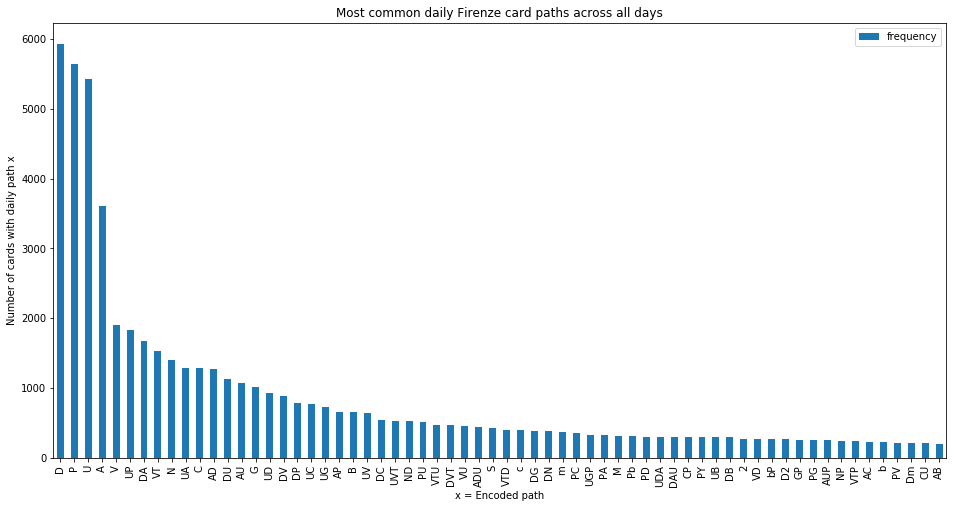

In [35]:
pt2[pt2['frequency']>200].plot.bar(figsize=(16,8))
plt.title('Most common daily Firenze card paths across all days')
plt.xlabel('x = Encoded path')
plt.ylabel('Number of cards with daily path x')
# plt.yscale('log')
plt.show()

In [36]:
nodes.head()

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b


In [37]:
# For reference, here are the displayed museums
# nodes[['string','short_name']].set_index('string').reindex(['D','P','U','A','V','T','N','C','G','B','S','c','m','M','b','Y','2'])
nodes[nodes['string'].isin(['D','P','U','A','V','T','N','C','G','B','S','c','m','M','b','Y','2'])][['string','short_name']]

,string,short_name
0,C,Santa Croce
1,2,San Lorenzo
2,D,Opera del Duomo
4,b,Brancacci
5,c,Cappelle Medicee
9,U,Uffizi
10,A,Accademia
19,M,M. San Marco
20,N,M. Santa Maria Novella
23,G,M. Galileo


In [38]:
df6[pd.isnull(df6[0].str[0])].head()

,0,1,2,3
user_id,,,,


In [26]:
df6.to_csv('encoded_paths.csv')

In [27]:
nodes.to_csv('encoded_paths_legend.csv')

In [39]:
df6.values

array([['U3A', 'DGVBC', nan, nan],
       ['U', 'D2V', 'PX', nan],
       ['U', 'D2V', 'PX', nan],
       ..., 
       ['D', nan, nan, nan],
       ['D', nan, nan, nan],
       ['D', nan, nan, nan]], dtype=object)